In [72]:
import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy

import netCDF4 as nc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
import arrow
import warnings
warnings.filterwarnings('ignore')

In [90]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [74]:
## retrieve days as arrow objects

start ='2015-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)

In [75]:
w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
depths = w['gdept_1d'][0,:]

In [76]:
#LO_AOUmethod_stoicCO_diseq_allup_y2015m12d29_preind_DIC.nc

newPI_DIC = np.zeros([365,40,950])
newPI_sigma0 = np.zeros([365,40,950])
for i in range(0,365):

    tdate = arrow_array[i][0]
    yy = tdate.format('YYYY')
    mm = tdate.format('MM')
    dd = tdate.format('DD')
    ymd = f'y{yy}m{mm}d{dd}'

#     if i%60 == 0:
        #print(ymd)
    newPI = nc.Dataset(f'./preind_DIC/LO_AOUmethod_stoicCO_diseq_allup_{ymd}_preind_DIC.nc')
   # print(newPI)
    newPI_DIC[i,:,:] = newPI['preindustrial_DIC']['preind_dic'][:,:] 
    newPI_sigma0[i,:,:] = newPI['preindustrial_DIC']['sigma0'][:,:] 
    newPI.close()

In [77]:
#retreive present day DIC and salinity
presday_DIC = np.zeros([365,40,950])
presday_TA = np.zeros([365,40,950])
presday_sal = np.zeros([365,40,950])

for i in range(0,365):

    tdate = arrow_array[i][0]
    #ymd = tdate.format('YYYY')
    yy = tdate.format('YYYY')
    mm = tdate.format('MM')
    dd = tdate.format('DD')
    ymd = f'y{yy}m{mm}d{dd}.nc'

#     if i%60 == 0:
#         #print(ymd)
    presday = nc.Dataset(f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_{ymd}')
    presday_DIC[i,:,:] = presday['DIC'][0,:,0,:]
    presday_TA[i,:,:] = presday['TA'][0,:,0,:]
    presday_sal[i,:,:] = presday['vosaline'][0,:,0,:]
    presday.close()



[21.69783211 21.74995995 21.87348366 22.01790619 22.16774178 22.3262291
 22.4851799  22.64118958 22.79384804 22.93989754 23.08110619 23.212677
 23.33813477 23.45323563 23.5628376  23.66870117 23.77371788 23.88545418
 24.0104351  24.16179657 24.36294556 24.64698982 25.07310104 25.62399864
 26.05543518 26.31377029 26.46890068 26.55713844 26.6040554  26.63273048
 26.65213966 26.67111778 26.69206619 26.70069122 26.70665741 26.70665741
 26.70665741 26.70665741 26.70665741 26.70665741]


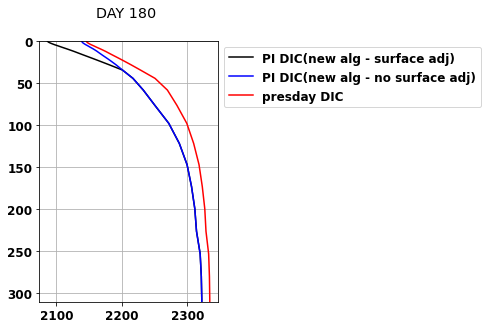

In [78]:
#tp testprof
presday_DIC_tp = presday_DIC[180,:,250]
newPI_DIC_tp = newPI_DIC[180,:,250]
newPI_sigma0_tp = newPI_sigma0[180,:,250]

print(newPI_sigma0_tp)

min_over25 = (np.min(newPI_sigma0_tp[newPI_sigma0_tp>25]))
loc_min_over25 = (np.where(newPI_sigma0_tp == min_over25))
intrusion_at_min = presday_DIC_tp[loc_min_over25] - \
    newPI_DIC_tp[loc_min_over25]

# print(intrusion_at_min)

#print(depths[loc_min_over25])
surf_int = 60
diff = surf_int - intrusion_at_min
depth_way = depths/depths[loc_min_over25]

#print(depth_way)

surf_intr = np.zeros_like(newPI_sigma0_tp)
surf_intr = surf_int - (depth_way) * (diff)
#print(surf_intr)
#print(surf_intr[22])

newPI_DIC_surfadj_tp = np.copy(newPI_DIC_tp)
#print(loc_min_over25[0][0])
newPI_DIC_surfadj_tp[0:loc_min_over25[0][0]] = \
presday_DIC_tp[0:loc_min_over25[0][0]]-surf_intr[0:loc_min_over25[0][0]]

fact = 0.8
fig, axs = plt.subplots(1,1, figsize=(4*fact, 6*fact), facecolor='w', edgecolor='k')
#plt.xticks(rotation=70)
axs.plot(newPI_DIC_surfadj_tp, depths, color = 'k', \
            linestyle = '-', label = 'PI DIC(new alg - surface adj)' )
axs.plot(newPI_DIC_tp, depths, color = 'b', \
            linestyle = '-', label = 'PI DIC(new alg - no surface adj)' )
axs.plot(presday_DIC_tp, depths, color = 'r', \
            linestyle = '-', label = 'presday DIC' )

plt.suptitle('DAY 180')
axs.grid();
axs.set_ylim([0,310])
axs.invert_yaxis()
axs.legend(bbox_to_anchor = [1,1])

[22.84553719 22.86240196 22.90033531 22.96417809 23.04379082 23.12929916
 23.21535873 23.29925728 23.38328743 23.466362   23.54703522 23.623703
 23.6972332  23.76559067 23.82992744 23.88977814 23.94636154 24.0017128
 24.05799866 24.11895561 24.18557739 24.26007652 24.34393311 24.4310894
 24.56898499 24.82019997 25.16605759 25.55842781 25.8359642  26.00095367
 26.09543228 26.17272949 26.22332573 26.23884392 26.24425316 26.24425316
 26.24425316 26.24425316 26.24425316 26.24425316]


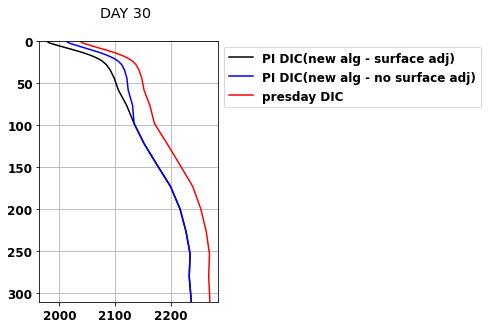

In [79]:
#tp testprof
presday_DIC_tp = presday_DIC[30,:,250]
newPI_DIC_tp = newPI_DIC[30,:,250]
newPI_sigma0_tp = newPI_sigma0[30,:,250]

print(newPI_sigma0_tp)

min_over25 = (np.min(newPI_sigma0_tp[newPI_sigma0_tp>25]))
loc_min_over25 = (np.where(newPI_sigma0_tp == min_over25))
intrusion_at_min = presday_DIC_tp[loc_min_over25] - \
    newPI_DIC_tp[loc_min_over25]

# print(intrusion_at_min)

#print(depths[loc_min_over25])
surf_int = 60
diff = surf_int - intrusion_at_min
depth_way = depths/depths[loc_min_over25]

#print(depth_way)

surf_intr = np.zeros_like(newPI_sigma0_tp)
surf_intr = surf_int - (depth_way) * (diff)
#print(surf_intr)
#print(surf_intr[22])

newPI_DIC_surfadj_tp = np.copy(newPI_DIC_tp)
#print(loc_min_over25[0][0])
newPI_DIC_surfadj_tp[0:loc_min_over25[0][0]] = \
presday_DIC_tp[0:loc_min_over25[0][0]]-surf_intr[0:loc_min_over25[0][0]]

fact = 0.8
fig, axs = plt.subplots(1,1, figsize=(4*fact, 6*fact), facecolor='w', edgecolor='k')
#plt.xticks(rotation=70)
axs.plot(newPI_DIC_surfadj_tp, depths, color = 'k', \
            linestyle = '-', label = 'PI DIC(new alg - surface adj)' )
axs.plot(newPI_DIC_tp, depths, color = 'b', \
            linestyle = '-', label = 'PI DIC(new alg - no surface adj)' )
axs.plot(presday_DIC_tp, depths, color = 'r', \
            linestyle = '-', label = 'presday DIC' )

plt.suptitle('DAY 30')
axs.grid();
axs.set_ylim([0,310])
axs.invert_yaxis()
axs.legend(bbox_to_anchor = [1,1])

In [80]:
def toy_interpolator(sigma0_prof,PI_dic_prof, presday_dic_prof, surf_dic):
    
#tp testprof
    presday_DIC_tp = presday_dic_prof
    newPI_DIC_tp = PI_dic_prof
    newPI_sigma0_tp = sigma0_prof
    
#     print(newPI_sigma0_tp)

    min_over25 = (np.min(newPI_sigma0_tp[newPI_sigma0_tp>25]))
    loc_min_over25 = (np.where(newPI_sigma0_tp == min_over25))
    intrusion_at_min = presday_DIC_tp[loc_min_over25] - \
        newPI_DIC_tp[loc_min_over25]

    # print(intrusion_at_min)

    #print(depths[loc_min_over25])
    surf_int = 60
    diff = surf_int - intrusion_at_min
    depth_way = depths/depths[loc_min_over25]

    #print(depth_way)

    surf_intr = np.zeros_like(newPI_sigma0_tp)
    surf_intr = surf_int - (depth_way) * (diff)
    #print(surf_intr)
    #print(surf_intr[22])

    newPI_DIC_surfadj_tp = np.copy(newPI_DIC_tp)
    #print(loc_min_over25[0][0])
    newPI_DIC_surfadj_tp[0:loc_min_over25[0][0]] = \
    presday_DIC_tp[0:loc_min_over25[0][0]]-surf_intr[0:loc_min_over25[0][0]]
    
    return newPI_DIC_surfadj_tp


In [81]:
newPI_DIC_surfadj = np.copy(newPI_DIC)

In [82]:
#newPI_sigma0

print(np.shape(newPI_DIC_surfadj))

for d in range(0,365):
    if d%60 == 0:
        print(d)
    for w in range(0,950):
        
        surfadj =\
        toy_interpolator(newPI_sigma0[d,:,w],newPI_DIC[d,:,w], presday_DIC[d,:,w], 60)
#         print(np.shape(surfadj))
#         print(surfadj)
        newPI_DIC_surfadj[d,:,w] = surfadj
        
        

(365, 40, 950)
0
60
120
180
240
300
360


In [83]:
# diff = newPI_DIC-newPI_DIC_surfadj
# # print(np.shape(diff))
# # print(np.nanmax(diff[:,0,:]))

# print((np.nanmean(newPI_DIC,axis = 0)))
# print('x')
# print((np.nanmean(newPI_DIC_surfadj,axis = 0)))

In [84]:
## averages

newPI_DIC_monthly = np.zeros([12,40,950])
newPI_DIC_surfadj_monthly = np.zeros([12,40,950])
oldPI_DIC_monthly = np.zeros([12,40,950])
presday_DIC_monthly = np.zeros([12,40,950])
presday_TA_monthly = np.zeros([12,40,950])
newPI_sigma0_monthly = np.zeros([12,40,950])


for i in range(0,12):
    #print('whut')
    newPI_DIC_surfadj_monthly[i,:,:] = \
        np.nanmean(newPI_DIC_surfadj[(i*30):((i+1)*30),:,:], axis = 0)
    #print(newPI_DIC_surfadj_monthly[i,:,250])
    #print('x')
    newPI_DIC_monthly[i,:,:] = \
        np.nanmean(newPI_DIC[(i*30):((i+1)*30),:,:], axis = 0)
    #print(newPI_DIC_monthly[i,:,250])
    
#     oldPI_DIC_monthly[i,:,:] = \
#         np.nanmean(oldPI_DIC[(i*30):((i+1)*30),:,:], axis = 0)
    presday_DIC_monthly[i,:,:] = \
        np.nanmean(presday_DIC[(i*30):((i+1)*30),:,:], axis = 0)
#     presday_TA_monthly[i,:,:] = \
#         np.nanmean(presday_TA[(i*30):((i+1)*30),:,:], axis = 0)
#     newPI_sigma0_monthly[i,:,:] = \
#         np.nanmean(newPI_sigma0[(i*30):((i+1)*30),:,:], axis = 0)

In [85]:
# print(newPI_DIC_surfadj_monthly[0,:,0])
# print(newPI_DIC_monthly[0,:,0])

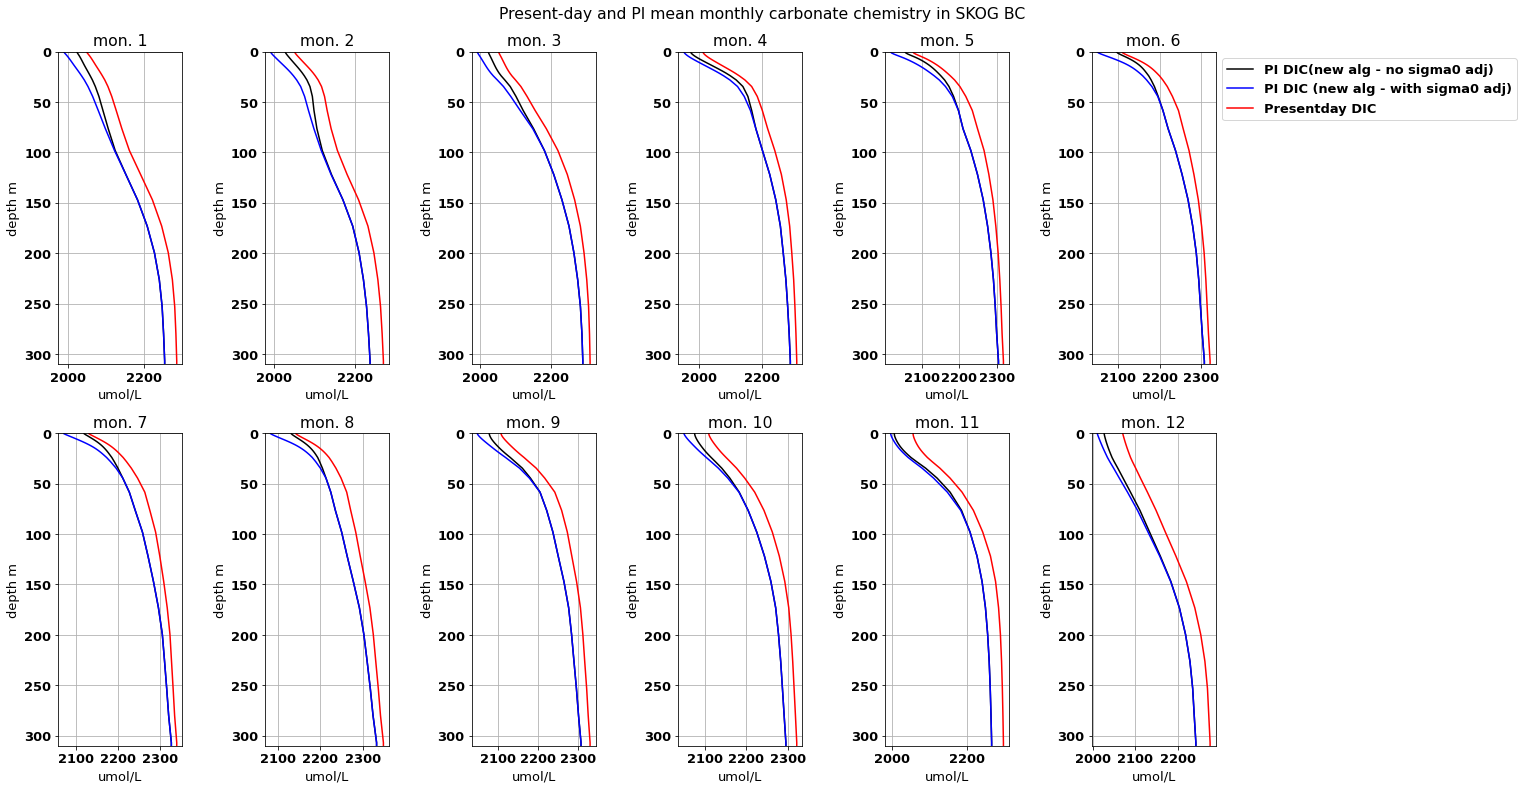

In [86]:
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 13}

plt.rc('font', **font)


w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

depths = w['gdept_1d'][0,:]

fact = 0.8
fig, axs = plt.subplots(2,6, figsize=(26.7*fact, 14*fact), facecolor='w', edgecolor='k')
#plt.xticks(rotation=70)

axs = axs.ravel()

for i in range(0,12):

    axs[i].plot(np.nanmean(newPI_DIC_monthly[i,:,:],axis = 1), \
                depths, color = 'k', \
                linestyle = '-', label = 'PI DIC(new alg - no sigma0 adj)')
    #print(np.nanmean(newPI_DIC_monthly[i,:,:],axis = 1))
#     axs[i].plot(np.nanmean(oldPI_DIC_monthly[i,:,:],axis = 1), \
#                 depths, color = 'skyblue', \
#                 linestyle = '-', label = 'PI DIC (old alg - no sigma0 adj)')        
    axs[i].plot(np.nanmean(newPI_DIC_surfadj_monthly[i,:,:],axis = 1), \
                depths, color = 'b', \
                linestyle = '-', label = 'PI DIC (new alg - with sigma0 adj)')
    #print(np.nanmean(newPI_DIC_surfadj_monthly[i,:,:],axis = 1))
    
    #print('x')
    axs[i].plot(np.nanmean(presday_DIC_monthly[i,:,:],axis = 1), \
                depths, color = 'r', \
                linestyle = '-', label = 'Presentday DIC')
#     axs[i].plot(np.nanmean(presday_TA_monthly[i,:,:],axis = 1), \
#                 depths, color = 'r', \
#                 linestyle = ':', label = 'Presentday - TA')
   # plt.xticks(rotation=70) 
for i in range(0,12):
    axs[i].grid();
    axs[i].set_ylim([0,310])
    axs[i].invert_yaxis()
    axs[i].set_title(f'mon. {i+1}')
    axs[i].set_ylabel('depth m')
    axs[i].set_xlabel('umol/L')

    
axs[5].legend(bbox_to_anchor = [1, 1])    
plt.suptitle('Present-day and PI mean monthly carbonate chemistry in SKOG BC')
plt.tight_layout()

Text(0.5, 0.98, 'PI DIC - with sigma adjustment - surface delta DIC = 60')

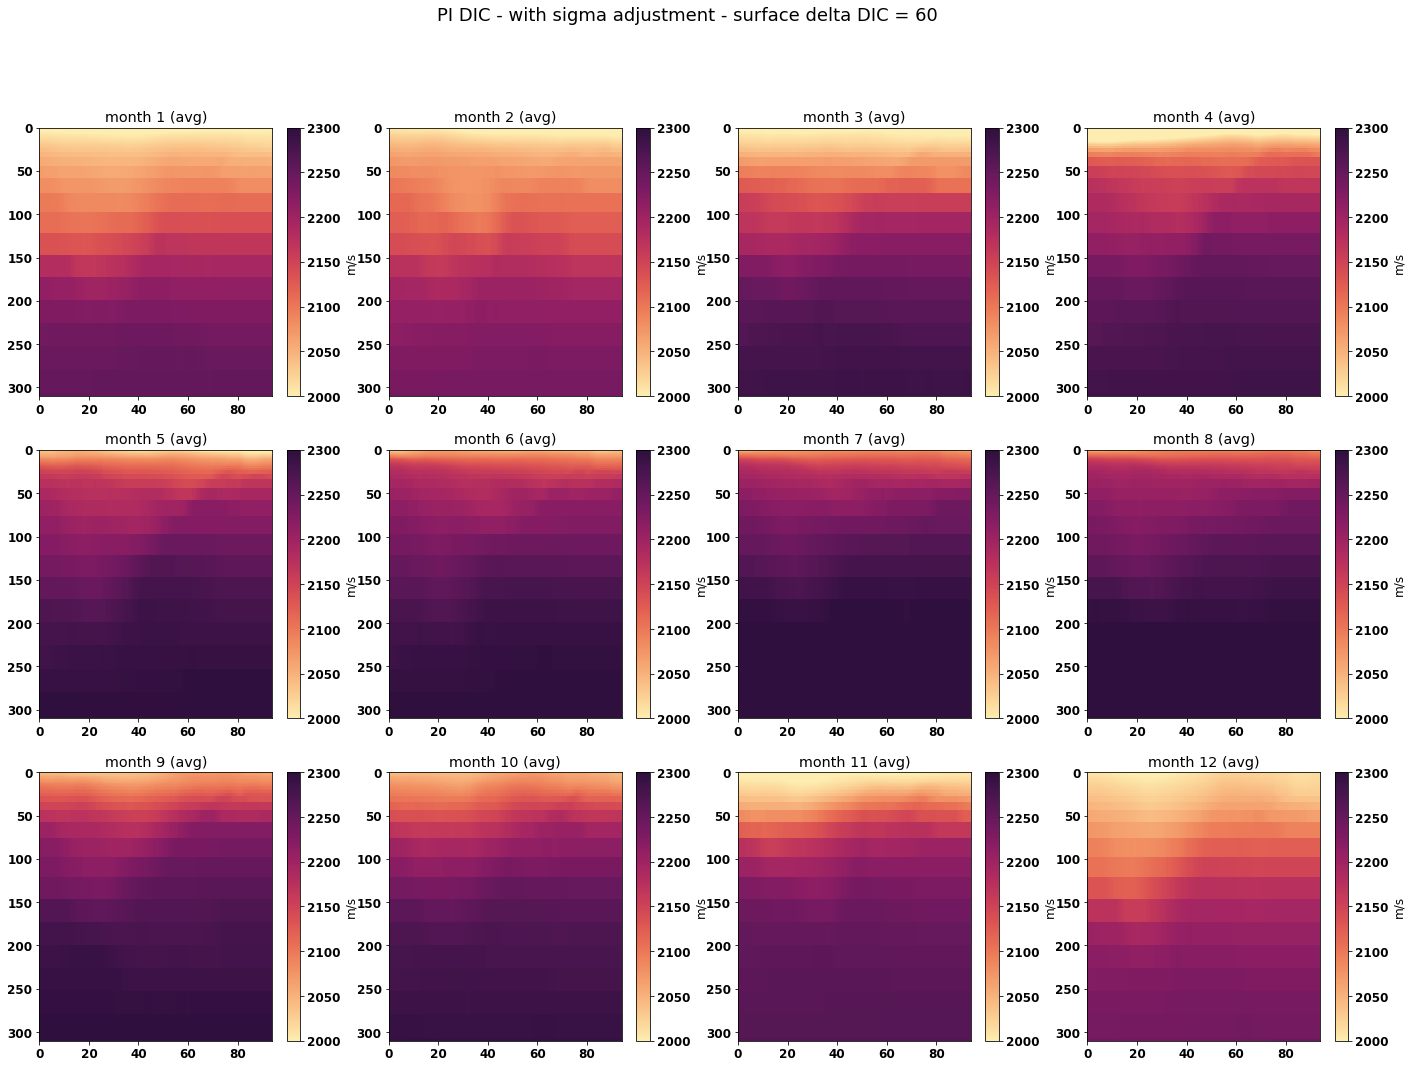

In [87]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 12}

# diff = preind_old_int-preind_new_int
# print(np.nanmean(diff[mask_bdy]))

#plt.pcolormesh(UTR_M3_s)
w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
# print(w['gdept_1d'])
depths = w['gdept_1d'][:]

# print(np.shape(UTR_M3_s))
# print(np.shape(ydir[0,:]))
# print(np.shape(depths[0,:]))

fact = 1.2
fig, axs = plt.subplots(3,4, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,12):
    section_slice = np.arange(0, 95,1)
    axs[i].set_ylim([0,310])
    axs[i].invert_yaxis()
    tplt2 = newPI_DIC_surfadj_monthly[i,:,950-95:950]
    tplt=np.ma.masked_values(tplt2,0)
    tcmap = cm.cm.balance
    cmap = tcmap
    mesh = axs[i].pcolormesh(section_slice,depths[0,:],tplt, cmap = cm.cm.matter, vmin=2000, vmax=2300 )
    fig.colorbar(mesh, ax=axs[i], label = 'm/s')
    #mesh = ax.pcolormesh(np.arange(0,4,1),np.arange(0,5,1),np.zeros([5,4]), cmap = tcmap, vmin=-5000, vmax=5000 )
    axs[i].set_title(f'month {i+1} (avg)')
    

plt.suptitle('PI DIC - with sigma adjustment - surface delta DIC = 60', fontsize = 18)

Text(0.5, 0.98, 'PI DIC - no sigma adjustment - surface delta DIC = 60')

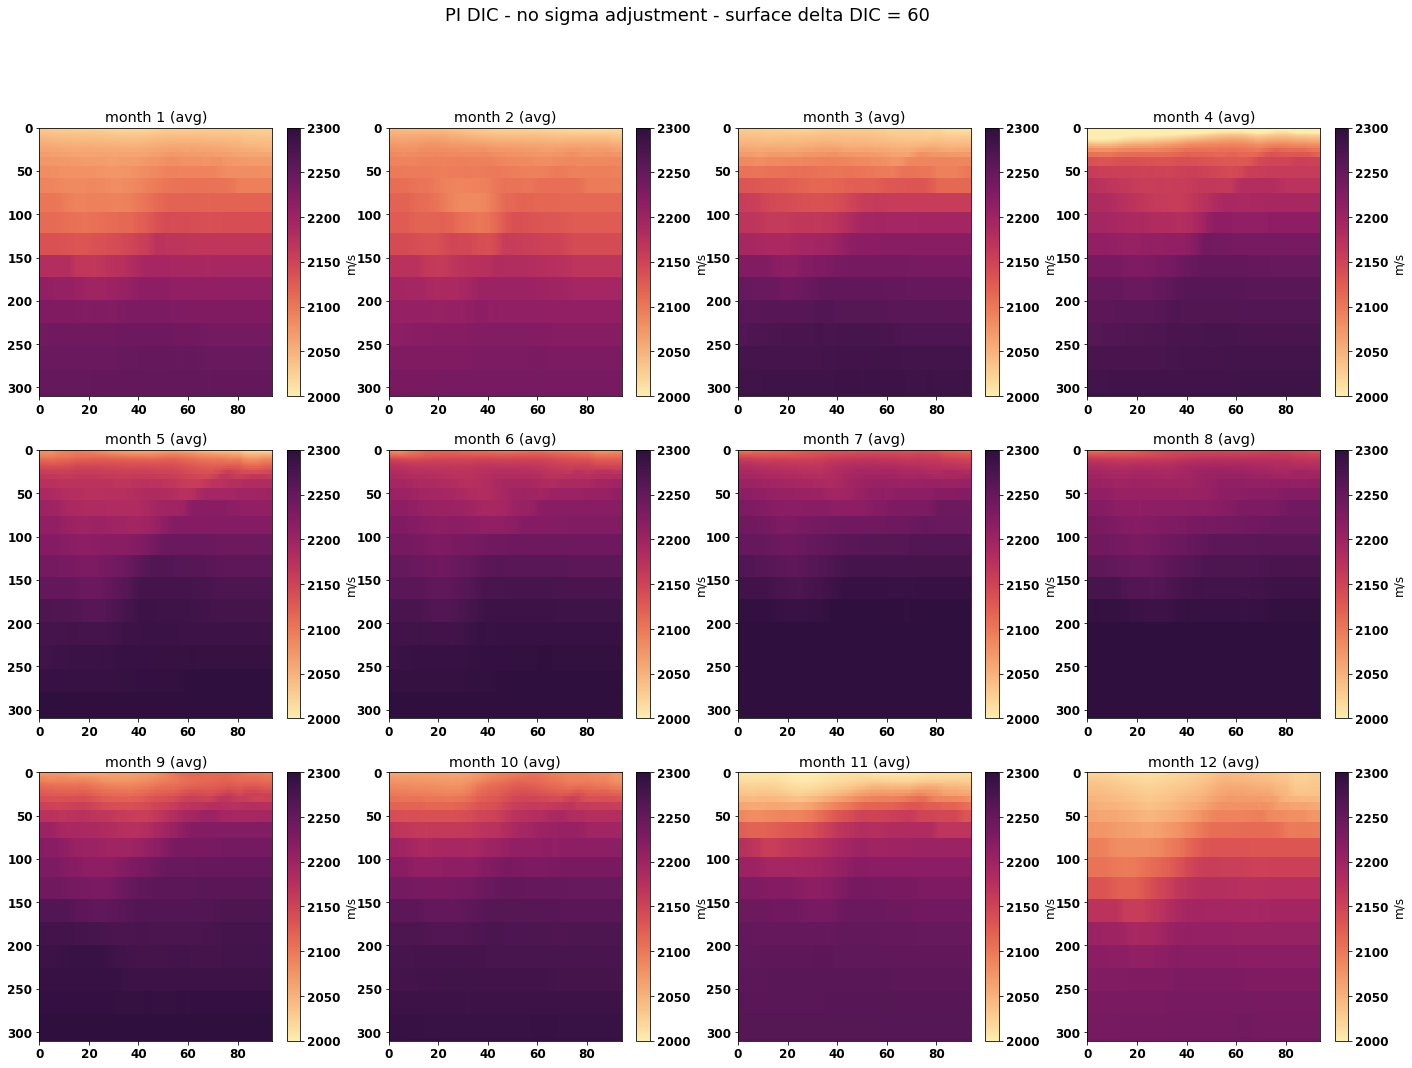

In [88]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 12}

# diff = preind_old_int-preind_new_int
# print(np.nanmean(diff[mask_bdy]))

#plt.pcolormesh(UTR_M3_s)
w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
# print(w['gdept_1d'])
depths = w['gdept_1d'][:]

# print(np.shape(UTR_M3_s))
# print(np.shape(ydir[0,:]))
# print(np.shape(depths[0,:]))

fact = 1.2
fig, axs = plt.subplots(3,4, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,12):
    section_slice = np.arange(0, 95,1)
    axs[i].set_ylim([0,310])
    axs[i].invert_yaxis()
    tplt2 = newPI_DIC_monthly[i,:,950-95:950]
#     print(np.shape(tplt2))
    tplt=np.ma.masked_values(tplt2,0)
    tcmap = cm.cm.balance
    cmap = tcmap
    mesh = axs[i].pcolormesh(section_slice,depths[0,:],tplt, cmap = cm.cm.matter, vmin=2000, vmax=2300 )
    fig.colorbar(mesh, ax=axs[i], label = 'm/s')
    #mesh = ax.pcolormesh(np.arange(0,4,1),np.arange(0,5,1),np.zeros([5,4]), cmap = tcmap, vmin=-5000, vmax=5000 )
    axs[i].set_title(f'month {i+1} (avg)')
    

plt.suptitle('PI DIC - no sigma adjustment - surface delta DIC = 60', fontsize = 18)

Text(0.5, 0.98, 'difference between sigma-adjusted and not (PI-DIC)')

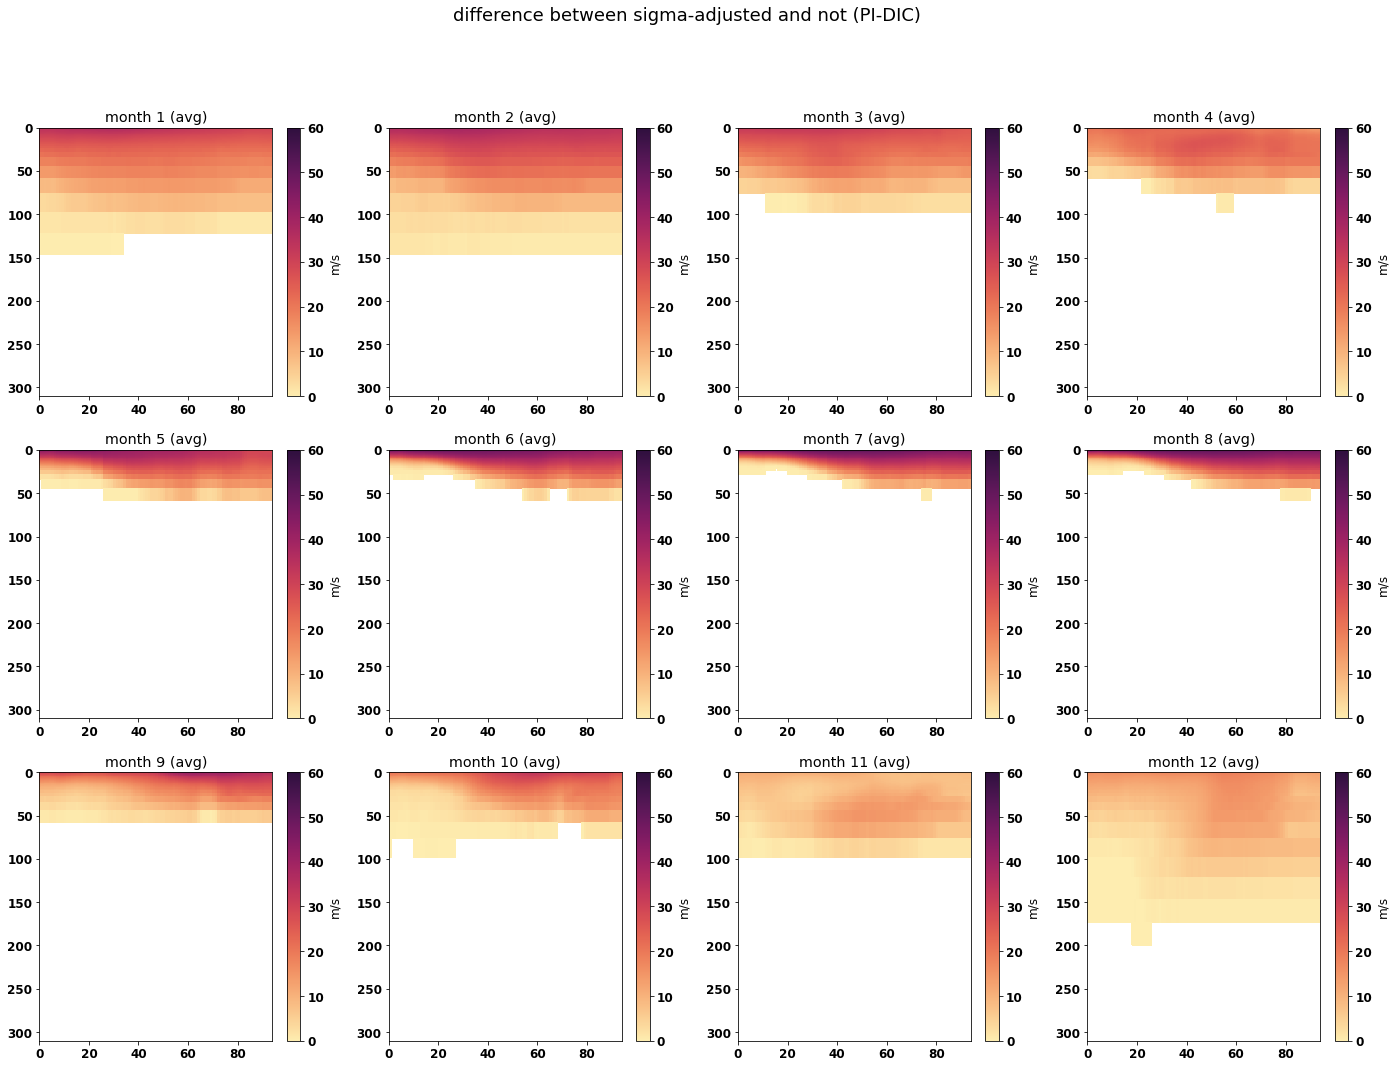

In [89]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 12}

# diff = preind_old_int-preind_new_int
# print(np.nanmean(diff[mask_bdy]))

#plt.pcolormesh(UTR_M3_s)
w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
# print(w['gdept_1d'])
depths = w['gdept_1d'][:]

# print(np.shape(UTR_M3_s))
# print(np.shape(ydir[0,:]))
# print(np.shape(depths[0,:]))

fact = 1.2
fig, axs = plt.subplots(3,4, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,12):
    section_slice = np.arange(0, 95,1)
    axs[i].set_ylim([0,310])
    axs[i].invert_yaxis()
    tplt2 = newPI_DIC_monthly[i,:,950-95:950]-newPI_DIC_surfadj_monthly[i,:,950-95:950]
#     print(np.shape(tplt2))
    tplt=np.ma.masked_values(tplt2,0)
    tcmap = cm.cm.balance
    cmap = tcmap
    mesh = axs[i].pcolormesh(section_slice,depths[0,:],tplt, cmap = cm.cm.matter, vmin=0, vmax=60 )
    fig.colorbar(mesh, ax=axs[i], label = 'm/s')
    #mesh = ax.pcolormesh(np.arange(0,4,1),np.arange(0,5,1),np.zeros([5,4]), cmap = tcmap, vmin=-5000, vmax=5000 )
    axs[i].set_title(f'month {i+1} (avg)')
    

plt.suptitle('difference between sigma-adjusted and not (PI-DIC)' , fontsize = 18)